# Emotie
## Details
> Door woorden met een emotionele connotatie te kiezen,word de morele gevoeligheid van de lezers geprikkeld, waardoor ze het achterliggende verhaal en diens details willen kennen. Verwijzingen naar emoties beïnvloeden de affectieve waarneming van de lezers en activerenzo gevoelens die vervolgens de aandacht van de lezers trekken. Er wordt dus via woorden op de gemoedstoestand van de lezers ingespeeld, bijvoorbeeld triestheid,boosheid, verontwaardiging, …
## Example
> Het *tragische* verhaal van Demi Lovato: wereldwijd *aanbeden*,maar *gelukkig* werd ze nooit

## Data

In [1]:
from util import get_cls_train_test

train_x, train_y, test_x, test_y = get_cls_train_test("Emotie")
train_y.value_counts()

0    612
1     69
Name: Emotie, dtype: int64

The data is quite imbalanced. Later in this notebook, you can find a section where we try to fix this.

## Approach 1: EmoRoBerta
[EmoRoBERTa](https://huggingface.co/arpanghoshal/EmoRoBERTa) is a model used for emotion classification, but the problem with a lot of pre trained models, just like this one is that it's trained for English senteces.

In [2]:
# Code copied from https://huggingface.co/arpanghoshal/EmoRoBERTa
from transformers import RobertaTokenizerFast, TFRobertaForSequenceClassification, pipeline

tokenizer = RobertaTokenizerFast.from_pretrained("arpanghoshal/EmoRoBERTa")
model = TFRobertaForSequenceClassification.from_pretrained("arpanghoshal/EmoRoBERTa")

emotion = pipeline('sentiment-analysis',
                   model='arpanghoshal/EmoRoBERTa')

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at arpanghoshal/EmoRoBERTa.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at arpanghoshal/EmoRoBERTa.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [3]:
emotion("I'm happy I know you")

[{'label': 'joy', 'score': 0.9778696894645691}]

In [4]:
emotion("Grass is green")

[{'label': 'neutral', 'score': 0.8017604351043701}]

In [5]:
emotion("Ik ben gelukkig")

[{'label': 'neutral', 'score': 0.9955449104309082}]

As expected, using dutch sentences on an english model won’t work of course. Let’s try translating it to english:

In [6]:
# based on https://translate-python.readthedocs.io/en/latest/tutorial.html
from translate import Translator

translator = Translator(from_lang="dutch", to_lang="english")
translation = translator.translate("Ik ben gelukkig.")
print(translation)

I am happy!


In [7]:
translator.translate("Deze manier om zinnen te vertalen werkt wel goed voor korte zinnen, maar geeft bij lange zinnen wel een probleem.")

RuntimeError: generator raised StopIteration

This translation method won't work on longer sentences, so let's use another library. (googletrans also didn't work for longer/more sentences, so using deep_translator).

In [8]:
from deep_translator import GoogleTranslator
from transformers import RobertaTokenizerFast, TFRobertaForSequenceClassification, pipeline

tokenizer = RobertaTokenizerFast.from_pretrained("arpanghoshal/EmoRoBERTa")
model = TFRobertaForSequenceClassification.from_pretrained("arpanghoshal/EmoRoBERTa")

emotion = pipeline('sentiment-analysis',
                   model='arpanghoshal/EmoRoBERTa')

# translator= Translator(from_lang="dutch",to_lang="english")
# translator= Translator() # gtrans
translator = GoogleTranslator(source='nl', target='en')


def get_emotion(dutch_headline, verbose=False):
    print(dutch_headline) if verbose else None
    en_headline = translator.translate(dutch_headline)
    # en_headline = translator.translate(dutch_headline, src="nl",dest="en") # gtrans
    print(en_headline) if verbose else None
    emotion_labels = emotion(en_headline)
    return emotion_labels

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at arpanghoshal/EmoRoBERTa.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at arpanghoshal/EmoRoBERTa.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [9]:
sentence1 = "David bleef achter met 11 eurocent op zijn rekening door oplichters: \"Beschaamd om het te vertellen\""
sentence2 = "Waarom deze frituur er nu uitziet als een versterkte burcht"

In [10]:
get_emotion(sentence1, verbose=True)

David bleef achter met 11 eurocent op zijn rekening door oplichters: "Beschaamd om het te vertellen"
David was left with 11 cents in his account by scammers: "Embarrassed to tell"


[{'label': 'embarrassment', 'score': 0.9354324340820312}]

In [11]:
get_emotion(sentence2, verbose=True)

Waarom deze frituur er nu uitziet als een versterkte burcht
Why this chip shop now looks like a fortified castle


[{'label': 'curiosity', 'score': 0.612494707107544}]

It works and is able to classify the sentiment of the headline quite accurately. The problem is that e.g. “curiosity” gets seen as an emotion here, while it wasn’t labeled as an emotion in the manually labelled dataset.

In [18]:
def contains_emotion(headline):
    emotion = get_emotion(headline)[0]["label"]
    return emotion != "neutral" and emotion != "curiosity" and emotion != "optimism" and emotion != "approval"

  0%|          | 0/227 [00:00<?, ?it/s]

f-score: 0.35294117647058815
Confusion matrix: (TP: 157, FP: 42, FN: 13, TN: 15)
Accuracy=75.77% (172/227)


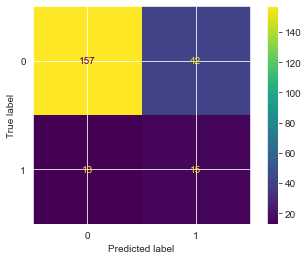

In [19]:
from util import print_evaluation
from tqdm.auto import tqdm
tqdm.pandas()
predictions = test_x.progress_apply(contains_emotion)
print_evaluation(test_y, predictions)

Because it has to translate everything, it’s a lot slower. As expected, there are quite a lot of false positives, which is probably because emotions like “Approval” or “Curiosity” are not seen as emotions in the original dataset. This problem was solved by checking the [different emotions](https://huggingface.co/arpanghoshal/EmoRoBERTa/blob/main/config.json) and adding the ones that seemed quite neutral. However, the results are still worse than expected.

## Approach 2: Tf-Idf
Bag of Words (tf-idf) might also work quite well here and probably give good results, since most sentences containing an emotion will contain a word with an emotion as stem.

f-score: 0.0
Confusion matrix: (TP: 199, FP: 0, FN: 29, TN: 0)
Accuracy=87.28% (199/228)


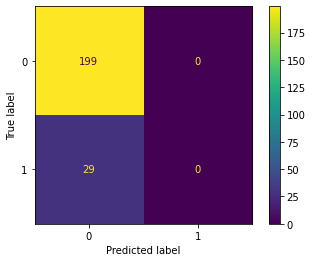

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from util import print_evaluation

model = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()), # count-vectorizer + tfidftransformer is same as tfidfvectorizer
    ('clf', LogisticRegression()),
])

model.fit(train_x, train_y)

predictions = model.predict(test_x)
print_evaluation(test_y, predictions)

There were zero instances classified as “Emotie” in the test set.

## Approach 3: Stemming
Let’s try to add better tokenization/stemming as an attempt to improve this.

f-score: 0.33333333333333326
Confusion matrix: (TP: 198, FP: 1, FN: 23, TN: 6)
Accuracy=89.47% (204/228)


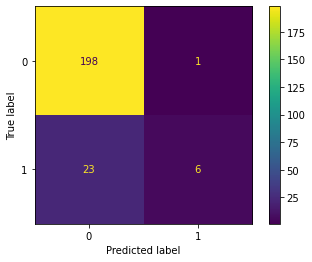

In [3]:
from sklearn import svm
from util import stem_analyzer

from sklearn.feature_extraction.text import TfidfVectorizer

model = Pipeline([
    ('vectorizer', TfidfVectorizer(analyzer=stem_analyzer)),
    ('classifier', svm.LinearSVC(random_state=0))
])

model.fit(train_x, train_y)

predictions = model.predict(test_x)
print_evaluation(test_y, predictions)

### Intermezzo: Fixing Data imbalance
#### Attempt 1: Reduce max features
[This article](https://www.deepwizai.com/projects/how-to-correctly-use-tf-idf-with-imbalanced-data) suggests reducing the max_features hyperparameter, but that didn't make an significant difference:

f-score: 0.0
Confusion matrix: (TP: 199, FP: 0, FN: 29, TN: 0)
Accuracy=87.28% (199/228)


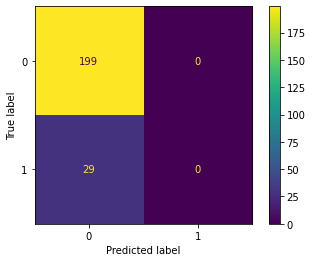

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

model = Pipeline([
    ('vect', TfidfVectorizer(analyzer=stem_analyzer, max_features=3)),
    ('clf', svm.LinearSVC()),
])

model.fit(train_x, train_y)

predictions = model.predict(test_x)
print_evaluation(test_y, predictions)

f-score: 0.33333333333333326
Confusion matrix: (TP: 198, FP: 1, FN: 23, TN: 6)
Accuracy=89.47% (204/228)


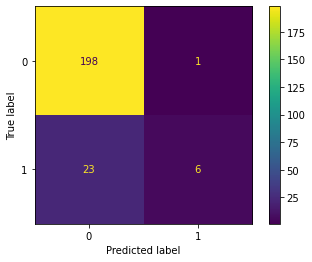

In [7]:
from util import fit_predict_evaluate

from sklearn.feature_extraction.text import TfidfVectorizer

model = Pipeline([
    ('vect', TfidfVectorizer(analyzer=stem_analyzer, max_features=999999)),
    ('clf', svm.LinearSVC()),
])

fit_predict_evaluate(model, train_x, train_y, test_x, test_y)

When the maximum number of features is too low, everything is classified the same, which is what we wanted to avoid. A higher maximum number of features already classifies some features as positive, but still not as many as I would like.

#### Attempt 2: Over sampling
Generate extra samples from the minority class.
##### Method 1: Random
Randomly repeat some samples

f-score: 0.358974358974359
Confusion matrix: (TP: 196, FP: 3, FN: 22, TN: 7)
Accuracy=89.04% (203/228)


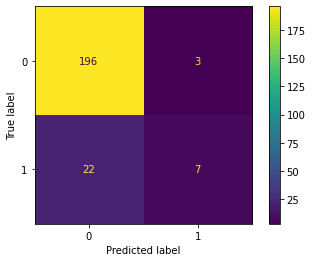

In [10]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

model = Pipeline([
    ('vect', TfidfVectorizer(analyzer=stem_analyzer)),
    ('resampler', RandomOverSampler(random_state=42)),
    ('clf', svm.LinearSVC()),
])

fit_predict_evaluate(model, train_x, train_y, test_x, test_y)

##### Method 2: SMOTE
SMOTE is a technique for generating synthetic samples from the minority class.

f-score: 0.358974358974359
Confusion matrix: (TP: 196, FP: 3, FN: 22, TN: 7)
Accuracy=89.04% (203/228)


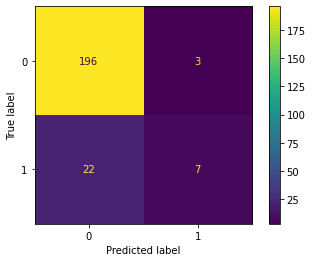

In [11]:
from imblearn.over_sampling import SMOTE

model = Pipeline([
    ('vect', TfidfVectorizer(analyzer=stem_analyzer)),
    ('resampler', SMOTE(random_state=42)),
    ('clf', svm.LinearSVC()),
])

fit_predict_evaluate(model, train_x, train_y, test_x, test_y)

##### Method 3: Borderline SMOTE

f-score: 0.358974358974359
Confusion matrix: (TP: 196, FP: 3, FN: 22, TN: 7)
Accuracy=89.04% (203/228)


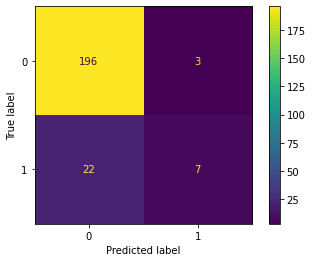

In [12]:
from imblearn.over_sampling import BorderlineSMOTE

model = Pipeline([
    ('vect', TfidfVectorizer(analyzer=stem_analyzer)),
    ('resampler', BorderlineSMOTE(random_state=42)),
    ('clf', svm.LinearSVC()),
])

fit_predict_evaluate(model, train_x, train_y, test_x, test_y)

##### Method 4: ADASYN
> The advantage of ADASYN over SMOTE is the use a weighted distribution for different minority class samples according to their level of difficulty in learning, where more synthetic data is generated for minority class samples that are harder to learn compared to those minority samples that are easier to learn.

f-score: 0.358974358974359
Confusion matrix: (TP: 196, FP: 3, FN: 22, TN: 7)
Accuracy=89.04% (203/228)


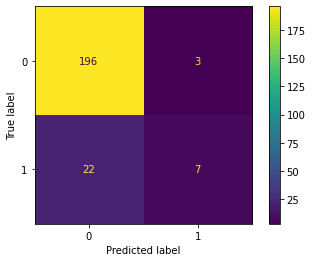

In [13]:
from imblearn.over_sampling import ADASYN

model = Pipeline([
    ('vect', TfidfVectorizer(analyzer=stem_analyzer)),
    ('resampler', ADASYN(random_state=42)),
    ('clf', svm.LinearSVC()),
])

fit_predict_evaluate(model, train_x, train_y, test_x, test_y)

All those oversampling methods give exactly the same results.

#### Attempt 2: Undersampling
##### Method 1: Random

f-score: 0.41441441441441446
Confusion matrix: (TP: 140, FP: 59, FN: 6, TN: 23)
Accuracy=71.49% (163/228)


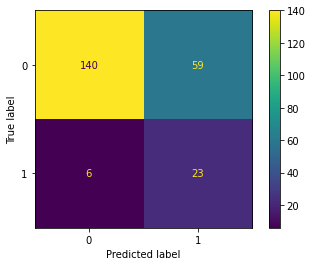

In [14]:
from imblearn.under_sampling import RandomUnderSampler

model = Pipeline([
    ('vect', TfidfVectorizer(analyzer=stem_analyzer)),
    ('resampler', RandomUnderSampler(random_state=42)),
    ('clf', svm.LinearSVC()),
])

fit_predict_evaluate(model, train_x, train_y, test_x, test_y)

##### Method 2: Near Miss


###NearMiss(version=1)###
f-score: 0.3018867924528302
Confusion matrix: (TP: 93, FP: 106, FN: 5, TN: 24)
Accuracy=51.32% (117/228)

###NearMiss(version=2)###
f-score: 0.37499999999999994
Confusion matrix: (TP: 124, FP: 75, FN: 5, TN: 24)
Accuracy=64.91% (148/228)

###NearMiss(version=3)###
f-score: 0.3333333333333333
Confusion matrix: (TP: 128, FP: 71, FN: 9, TN: 20)
Accuracy=64.91% (148/228)


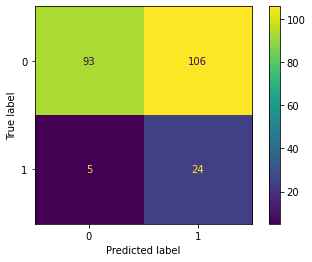

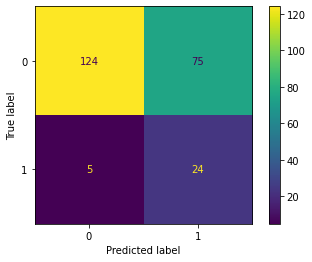

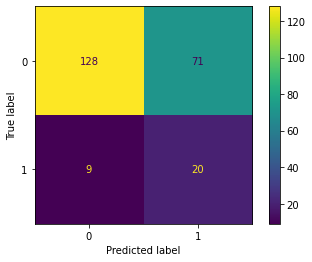

In [16]:
from imblearn.under_sampling import NearMiss

for sampler in (NearMiss(version=1), NearMiss(version=2), NearMiss(version=3)):
    print(f"\n###NearMiss(version={sampler.version})###")

    model = Pipeline([
        ('vect', TfidfVectorizer(analyzer=stem_analyzer)),
        ('resampler', sampler),
        ('clf', svm.LinearSVC()),
    ])

    fit_predict_evaluate(model, train_x, train_y, test_x, test_y)

##### Method 3: Condensed Nearest Neighbors


###CondensedNearestNeighbour(random_state=42)###


C:\Users\arnod\AppData\Roaming\Python\Python39\site-packages\sklearn\neighbors\_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\arnod\AppData\Roaming\Python\Python39\site-packages\sklearn\neighbors\_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will

f-score: 0.4090909090909091
Confusion matrix: (TP: 193, FP: 6, FN: 20, TN: 9)
Accuracy=88.60% (202/228)

###OneSidedSelection(random_state=42)###
f-score: 0.3783783783783784
Confusion matrix: (TP: 198, FP: 1, FN: 22, TN: 7)
Accuracy=89.91% (205/228)


C:\Users\arnod\AppData\Roaming\Python\Python39\site-packages\sklearn\neighbors\_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)



###NeighbourhoodCleaningRule()###


C:\Users\arnod\AppData\Local\Programs\Python\Python39\lib\site-packages\imblearn\under_sampling\_prototype_selection\_edited_nearest_neighbours.py:158: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  nnhood_label, _ = mode(nnhood_label, axis=1)


f-score: 0.33333333333333326
Confusion matrix: (TP: 198, FP: 1, FN: 23, TN: 6)
Accuracy=89.47% (204/228)


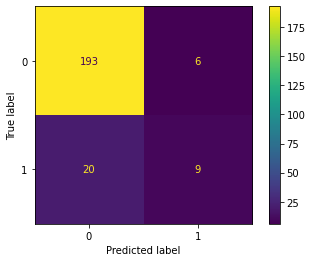

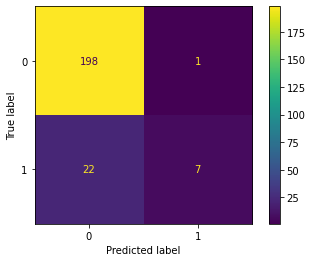

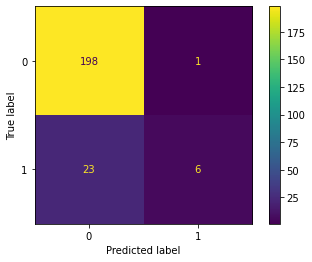

In [20]:
from imblearn.under_sampling import CondensedNearestNeighbour, OneSidedSelection, NeighbourhoodCleaningRule

# Sorry for the warning stam, I can't add keepdims=True to the arguments of the functions
for sampler in (CondensedNearestNeighbour(random_state=42),
                OneSidedSelection(random_state=42),
                NeighbourhoodCleaningRule()):
    print(f"\n###{sampler}###")

    model = Pipeline([
        ('vect', TfidfVectorizer(analyzer=stem_analyzer)),
        ('resampler', sampler),
        ('clf', svm.LinearSVC()),
    ])

    fit_predict_evaluate(model, train_x, train_y, test_x, test_y)

##### Method 4: Tomek Links


f-score: 0.3783783783783784
Confusion matrix: (TP: 198, FP: 1, FN: 22, TN: 7)
Accuracy=89.91% (205/228)


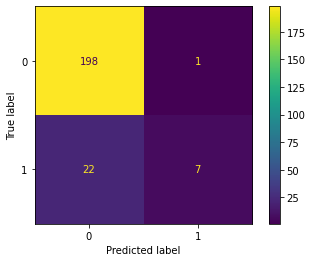

In [22]:
from imblearn.under_sampling import TomekLinks

model = Pipeline([
    ('vect', TfidfVectorizer(analyzer=stem_analyzer)),
    ('resampler', TomekLinks()),
    ('clf', svm.LinearSVC()),
])

fit_predict_evaluate(model, train_x, train_y, test_x, test_y)

Surprisingly, those under sampling methods all provided similar results to the over sampling methods (while I would expect worse results, since we have less training samples).

#### Attempt 4: Combining under and over sampling
##### Method 1: SMOTEENN

f-score: 0.22568093385214008
Confusion matrix: (TP: 0, FP: 199, FN: 0, TN: 29)
Accuracy=12.72% (29/228)


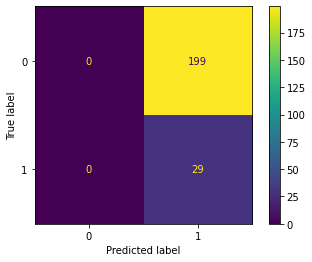

In [23]:
from imblearn.combine import SMOTEENN

model = Pipeline([
    ('vect', TfidfVectorizer(analyzer=stem_analyzer)),
    ('resampler', SMOTEENN(random_state=42)),
    ('clf', svm.LinearSVC()),
])

fit_predict_evaluate(model, train_x, train_y, test_x, test_y)

##### Method 2: SMOTETomek

f-score: 0.358974358974359
Confusion matrix: (TP: 196, FP: 3, FN: 22, TN: 7)
Accuracy=89.04% (203/228)


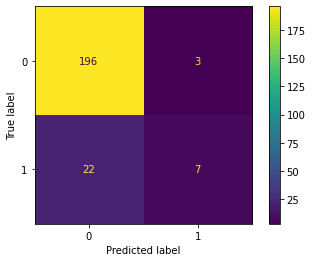

In [24]:
from imblearn.combine import SMOTETomek

model = Pipeline([
    ('vect', TfidfVectorizer(analyzer=stem_analyzer)),
    ('resampler', SMOTETomek(random_state=42)),
    ('clf', svm.LinearSVC()),
])

fit_predict_evaluate(model, train_x, train_y, test_x, test_y)

Smoteenn gives significantly worse results. SmoteTomek gives similar results to the other over or under sampling methods. However, the f-score is still low.

## Approach 4: BERTje
There is appearantly a dutch version of BERT. Let's see if we can use this for detecting the emotion. A lot of the code below is based on [this tutorial](https://towardsdatascience.com/sentiment-analysis-in-10-minutes-with-bert-and-hugging-face-294e8a04b671).

In [25]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

model = TFBertForSequenceClassification.from_pretrained("GroNLP/bert-base-dutch-cased")
tokenizer = BertTokenizer.from_pretrained("GroNLP/bert-base-dutch-cased")

model.summary()

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['classifier', 'bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109137408 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,138,946
Trainable params: 109,138,946
Non-trainable params: 0
_________________________________________________________________


Convert the data to examples:

In [27]:
from sklearn.model_selection import train_test_split
import pandas as pd

# concatenate train_x and train_y in a pandas dataframe

training_df = pd.concat([train_x, train_y], axis=1)
train_df, valid_df = train_test_split(training_df, test_size=0.2, random_state=42)

train_df.head()

,,Headline,Emotie
Test,,,
620,1545,Twintigers zetten huis in lichterlaaie na ruzi...,0
667,1664,Motorrijder zwaargewond na ongeval met auto,0
846,2112,Bpost langs alle kanten onder vuur voor hervor...,0
633,1582,Proximus-klanten kunnen gratis naar de Rode Du...,0
824,2061,"""Doe de gordijnen toch eens dicht"": koppel kri...",0


In [29]:
train_df[["Emotie"]].value_counts()

Emotie
0         485
1          59
dtype: int64

In [31]:
def df_to_input_example(df, data_column, label_column):
    return df.apply(lambda x: InputExample(guid=None,
                                           text_a=x[data_column],
                                           text_b=None,
                                           label=x[label_column]), axis=1)


train_InputExamples = df_to_input_example(train_df, "Headline", "Emotie")
validation_InputExamples = df_to_input_example(valid_df, "Headline", "Emotie")

In [32]:
import tensorflow as tf

# This function is also from the earlier mentioned article. I don't completely understands what it does, but if it provides good results, it's definetly worth looking deeper into it
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    """"
    This function will tokenize the InputExample objects, then create the required input format with the tokenized objects, finally, create an input dataset that we can feed to the model.
    """
    features = []  # -> will hold InputFeatures to be converted later

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length,  # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True,  # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
                                                     input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )

In [33]:
train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.shuffle(100).batch(32).repeat(2)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
validation_data = validation_data.batch(32)

C:\Users\arnod\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\tokenization_utils_base.py:2285: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [34]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

model.fit(train_data, epochs=2, validation_data=validation_data)

Epoch 1/2
34/34 [==============================] - 573s 15s/step - loss: 0.3062 - accuracy: 0.8906 - val_loss: 0.2098 - val_accuracy: 0.9270
Epoch 2/2
34/34 [==============================] - 738s 22s/step - loss: 0.1211 - accuracy: 0.9513 - val_loss: 0.2229 - val_accuracy: 0.9197


In [35]:
model.save_pretrained("bertje-emotion")
# You can get it back with following code: AutoModelForSequenceClassification.from_pretrained("path/to/model")

In [36]:
def predict_emotion_bert(pred_sentences):
    tf_batch = tokenizer(pred_sentences, max_length=128, padding=True, truncation=True, return_tensors='tf')
    tf_outputs = model(tf_batch)
    tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
    label = tf.argmax(tf_predictions, axis=1)
    label = label.numpy()
    return label

In [37]:
pred_sentences = ["Familie in rouw na tragisch ongeval: Gelukkig heeft hij niet moeten afzien",
                  "Voorzitter brengt dinsdag een bezoek aan Taiwan"]
predict_emotion_bert(pred_sentences)

array([0, 0], dtype=int64)

Hmm, first sentence contains quite some emotion, but is still classified as 0. Let's see how it performs on the test set:

f-score: 0.2702702702702703
Confusion matrix: (TP: 196, FP: 3, FN: 24, TN: 5)
Accuracy=88.16% (201/228)


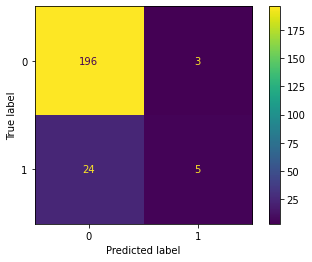

In [38]:
from sklearn import metrics
predictions = predict_emotion_bert(test_x.to_list())
print_evaluation(test_y, predictions)

Even though the model took quite some time to train, it still provides a slightly lower accuracy than just tf-idf and a lower f-score.